In [2]:
!pip install --user contractions

In [3]:
%pip install contractions

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import sys
sys.executable

'C:\\ProgramData\\anaconda3\\python.exe'

In [5]:
!pip install pyPDF2

Defaulting to user installation because normal site-packages is not writeable


In [6]:
!pip install pdfplumber

Defaulting to user installation because normal site-packages is not writeable


In [7]:
!pip install pdfReader

Defaulting to user installation because normal site-packages is not writeable


In [8]:
import pandas as pd
import numpy as np
import re
import string # for text cleaning
import contractions # for expanding short form words
from tqdm import tqdm
tqdm.pandas(desc="Progress Bar")
import matplotlib.pyplot as plt
import os
import PyPDF2
import pdfplumber
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [15]:
resumes = pd.read_csv(r"C:\Users\pc\Downloads\Resume.csv")
resumes.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [16]:
def text_cleaning(text:str) -> str:
    if pd.isnull(text):
        return

    # lower-case everything
    text = text.lower().strip()

    # For removing puctuations
    translator = str.maketrans('', '', string.punctuation)

    # expand all the short-form words
    text = contractions.fix(text)

    # remove any special chars
    text = re.sub(r'http\S+|www\S+|https\S+', '', text) # Remove URLs
    text = re.sub(r'\S+@\S+', '', text) # Remove emails
    text = re.sub(r'\b\d{1,3}[-./]?\d{1,3}[-./]?\d{1,4}\b', '', text) # Remove phone numbers
    text = text.translate(translator) # Remove puctuations
    text = re.sub(r'[^a-zA-Z]', ' ', text) # Remove other non-alphanumeric characters

    return text.strip()

In [17]:
resumes['Resume_str'] = resumes['Resume_str'].progress_apply(text_cleaning)
resumes.head()

Progress Bar: 100%|██████████| 2484/2484 [00:12<00:00, 200.59it/s]


,ID,Resume_str,Resume_html,Category
0,16852973,hr administratormarketing associate hr admini...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,hr specialist us hr operations summary ...,"<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,hr director summary over years e...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,hr specialist summary dedicated drive...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,hr manager skill highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [18]:
resumes.duplicated(subset=['Resume_str']).value_counts()

False    2482
True        2
Name: count, dtype: int64

In [19]:
resumes.drop_duplicates(subset=['Resume_str'], keep='first',inplace = True)
resumes.reset_index(inplace=True,drop=True)
resumes.head()

,ID,Resume_str,Resume_html,Category
0,16852973,hr administratormarketing associate hr admini...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,hr specialist us hr operations summary ...,"<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,hr director summary over years e...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,hr specialist summary dedicated drive...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,hr manager skill highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [34]:
resumes['Resume_str'][0]

'hr administratormarketing associate  hr administrator       summary     dedicated customer service manager with    years of experience in hospitality and customer service management   respected builder and leader of customerfocused teams strives to instill a shared enthusiastic commitment to customer service         highlights         focused on customer satisfaction  team management  marketing savvy  conflict resolution techniques     training and development  skilled multitasker  client relations specialist           accomplishments      missouri dot supervisor training certification  certified by ihg in customer loyalty and marketing by segment   hilton worldwide general manager training certification  accomplished trainer for cross server hospitality systems such as    hilton onq     micros    opera pms    fidelio    opera    reservation system ors    holidex    completed courses and seminars in customer service sales strategies inventory control loss prevention safety time manage

In [20]:
resumes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2482 entries, 0 to 2481
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2482 non-null   int64 
 1   Resume_str   2482 non-null   object
 2   Resume_html  2482 non-null   object
 3   Category     2482 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.7+ KB


In [21]:
resumes["Category"].value_counts()

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
FINANCE                   117
FITNESS                   117
AVIATION                  116
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

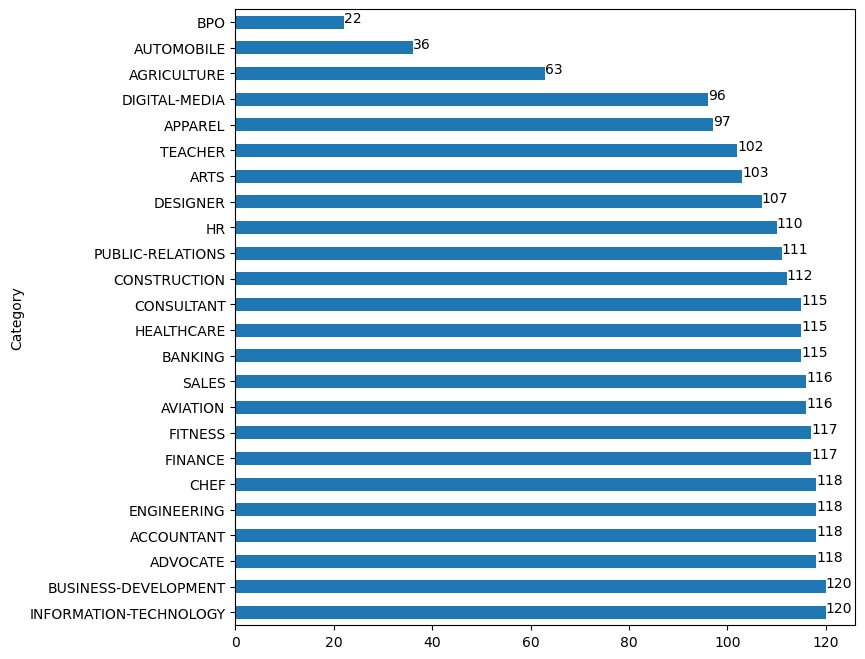

In [22]:
# We can see here the distribution of different CV categories

plt.figure(figsize=(8,8))

resumes.Category.value_counts().plot(kind='barh')

for index, value in enumerate(resumes.Category.value_counts().values):
    plt.text(value, index, str(value))

plt.show();

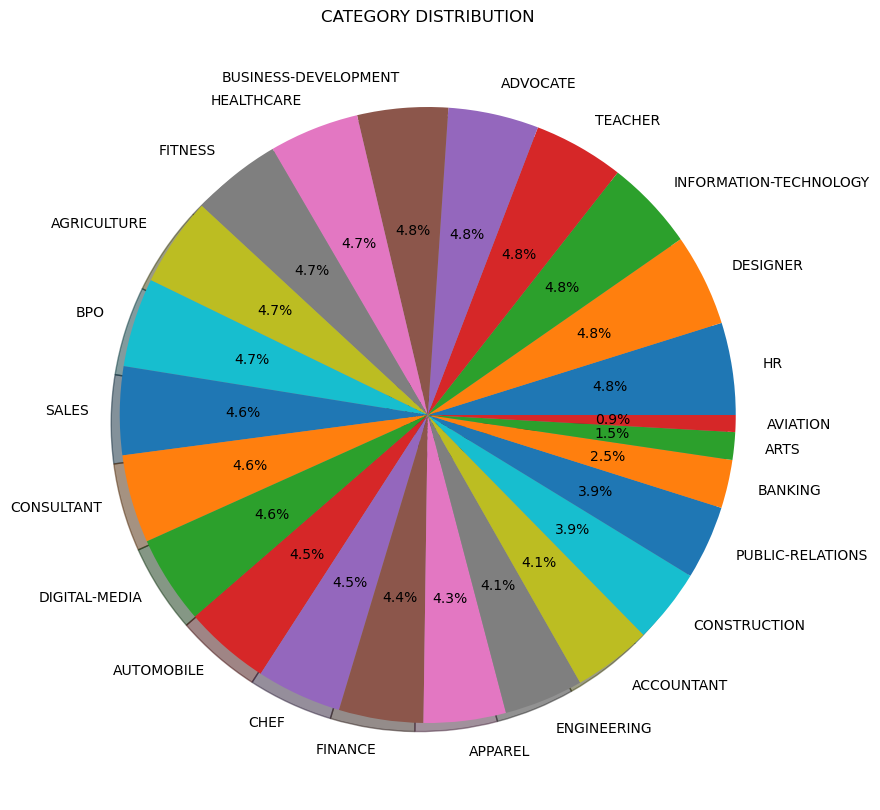

In [23]:
from matplotlib.gridspec import GridSpec
targetCounts = resumes['Category'].value_counts()
targetLabels  = resumes['Category'].unique()
# Make square figures and axes
plt.figure(1, figsize=(22,22))
the_grid = GridSpec(2, 2)


cmap = plt.get_cmap('coolwarm')
plt.subplot(the_grid[0, 1], aspect=1, title='CATEGORY DISTRIBUTION')

source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True)
plt.show()

# Ranking for Information_Technology resumes

In [24]:
Information_Technology="C:\\Users\\pc\\Downloads\\Information-Technology-Spoecialist-job-description.pdf"

In [25]:
Information_Technology_File = open(Information_Technology, 'rb')
Script = PyPDF2.PdfReader(Information_Technology_File)
pages = len(Script.pages)

In [26]:
Script_Information_Technology = []
with pdfplumber.open(Information_Technology_File) as pdf:
    for i in range (0,pages):
        page=pdf.pages[i]
        text=page.extract_text()
        print (text)
        Script_Information_Technology.append(text)

Information Technology Specialist - Job Description
Title: Information Technology Specialist
Reports To: Operations Manager
Immediate Direct Reports: none
Scope: In Scope
Summary
Reporting to the Operation Manager, the Information Technology Specialist is responsible for the
effective operation of information technology (IT) services and support across the organization.
The Information Technology Specialist serves as a technical expert for the development,
implementation, management, and support of systems and networks. The IT specialist plans and
carries out exciting, complex assignments and develops new methods and approaches in a wide
variety of IT specialties. They evaluate new and enhanced approaches to deliver IT services;
test and optimize the functionality of systems, networks, and data; and define technical
requirements. The Information Technology Specialist is responsible for providing various forms
of computer-related technical assistance and improving the efficiency of the 

In [27]:
Script_Information_Technology=''.join(Script_Information_Technology)
Information_Technology_Clear=Script_Information_Technology.replace("\n","")
Information_Technology_Clear

"Information Technology Specialist - Job DescriptionTitle: Information Technology SpecialistReports To: Operations ManagerImmediate Direct Reports: noneScope: In ScopeSummaryReporting to the Operation Manager, the Information Technology Specialist is responsible for theeffective operation of information technology (IT) services and support across the organization.The Information Technology Specialist serves as a technical expert for the development,implementation, management, and support of systems and networks. The IT specialist plans andcarries out exciting, complex assignments and develops new methods and approaches in a widevariety of IT specialties. They evaluate new and enhanced approaches to deliver IT services;test and optimize the functionality of systems, networks, and data; and define technicalrequirements. The Information Technology Specialist is responsible for providing various formsof computer-related technical assistance and improving the efficiency of the work of the s

In [36]:
# Filtrer les CVs de la catégorie "Information Technology"
it_resumes = resumes[resumes['Category'] == 'INFORMATION-TECHNOLOGY']

# Liste pour stocker le texte des CVs
it_resumes_text = it_resumes['Resume_str'].tolist()
it_resumes_text

['information technology         summary     dedicated  information assurance professional  wellversed in analyzing and mitigating risk and finding costeffective solutions excels at boosting performance and productivity by establishing realistic goals and enforcing deadlines  versatile it professional with    years of enterprise design and engineering methodology       skills          enterprise platforms  knowledge of product lifecycle management plm  project tracking  hardware and software upgrade planning  product requirements documentation  selfdirected  ms visio  decisive  collaborative  domain active directory layout  data storage engineering      information assurance  risk management framework rmf  active directory design and deployment  workstation build and deployment  systems accreditation packages  red hat enterprise linux installation and hardening  network design  troubleshooting   high performance computing            experience      company name    city     state    inf

In [37]:
cv = CountVectorizer()

ranking_list = []

# Boucle pour calculer la similarité cosinus entre chaque CV et la description de poste
for resume_text in it_resumes_text:
    text = [resume_text, Information_Technology_Clear]
    count_matrix = cv.fit_transform(text)
    similarity_score = cosine_similarity(count_matrix)[0][1] * 100
    ranking_list.append(similarity_score)

# Ajouter la colonne 'ID' pour récupérer l'ID original de chaque CV
resume_ids = it_resumes['ID'].tolist()  # Assurez-vous que la colonne 'ID' existe dans le CSV

# Classement des CVs selon leur score de similarité avec l'ID original
ranked_resumes = sorted(zip(resume_ids, ranking_list), key=lambda x: -x[1])

# Affichage du classement avec l'ID original
for cv_id, score in ranked_resumes:
    print(f"CV ID: {cv_id}, Similarity Score: {score:.2f}")

CV ID: 27372171, Similarity Score: 89.60
CV ID: 51363762, Similarity Score: 86.42
CV ID: 26801767, Similarity Score: 86.34
CV ID: 27295996, Similarity Score: 85.94
CV ID: 16533554, Similarity Score: 85.81
CV ID: 46260230, Similarity Score: 85.79
CV ID: 17641670, Similarity Score: 85.59
CV ID: 11957080, Similarity Score: 85.49
CV ID: 10840430, Similarity Score: 85.43
CV ID: 18159866, Similarity Score: 85.41
CV ID: 19796840, Similarity Score: 85.22
CV ID: 22450718, Similarity Score: 85.12
CV ID: 19850482, Similarity Score: 84.73
CV ID: 20879311, Similarity Score: 84.44
CV ID: 20674668, Similarity Score: 84.33
CV ID: 52246737, Similarity Score: 84.26
CV ID: 91635250, Similarity Score: 84.16
CV ID: 24020470, Similarity Score: 84.13
CV ID: 11584809, Similarity Score: 84.12
CV ID: 28672970, Similarity Score: 83.89
CV ID: 91697974, Similarity Score: 83.82
CV ID: 52618188, Similarity Score: 83.49
CV ID: 21283365, Similarity Score: 83.27
CV ID: 12045067, Similarity Score: 83.13
CV ID: 24913648,

#  performance of ranking model using Mean Reciprocal Rank (MRR) and Normalized Discounted Cumulative Gain (NDCG)

In [53]:
# Liste des 5 premiers IDs (ceux que tu as mentionnés)
top_5_ids = [27372171, 51363762, 26801767, 27295996, 16533554]

# Filtrer le DataFrame pour obtenir les CV correspondant aux 5 premiers IDs
top_5_resumes = resumes[resumes['ID'].isin(top_5_ids)]

# Afficher les CV correspondants
for index, row in top_5_resumes.iterrows():
    print(f"CV ID: {row['ID']}\n")
    print(row['Resume_str'])  # Affiche le texte du CV
    print("\n" + "="*50 + "\n")

CV ID: 26801767

director information technology           professional summary     resultsdriven it director with over    years of experience in diverse industries including port and higher education expertise includes team leadership technical architecture training and development disaster recovery planning and information protection analysis dynamic resourceful and extremely driven individual with a deep passion for creating and delivering programs and solutions that empower a team company and customer to meet and exceed desired expectations       core qualifications          it management  resultsoriented  operations management  budget administration  change management      problem resolution  team leadership  decisive leader  cost reduction            experience      director information technology    august    to   current     company name       city     state      manages information technology computer center for the board of commissioners of the port of new orleans board  deve

In [60]:
from sklearn.metrics import ndcg_score

# Scores de similarité des CV (remplace avec tes scores réels)
scores = [89.60, 86.42, 86.34, 85.94, 85.81]

# Relevance en fonction des positions des CVs
relevance = [1, 0, 1, 0, 1]  # Exemples de pertinence pour chaque CV

# Le score ndcg nécessite que les listes soient 2D
true_relevance = np.array([relevance])
predicted_scores = np.array([scores])

ndcg = ndcg_score(true_relevance, predicted_scores)
print(f"NDCG: {ndcg:.4f}")

NDCG: 0.8855


In [56]:
def calculate_mrr(relevance):
    for i, rel in enumerate(relevance):
        if rel == 1:
            return 1 / (i + 1)
    return 0

# Exemple : Liste de pertinence (1 si le CV est pertinent, 0 sinon)
relevance = [1, 0, 1, 0, 1]  # Par exemple, le 1er et le 3ème et le 4 émé CV sont pertinents
mrr = calculate_mrr(relevance)
print(f"MRR: {mrr:.4f}")

MRR: 1.0000


# Ranking for BUSINESS-DEVELOPMENT resumes

In [44]:
BUSINESS_DEVELOPMENT="‪C:\\Users\\pc\\Downloads\\business-development.pdf"

In [47]:
BUSINESS_DEVELOPMENT_File = open(r"C:\Users\pc\Downloads\business-development.pdf", 'rb')
Script = PyPDF2.PdfReader(BUSINESS_DEVELOPMENT_File)
pages = len(Script.pages)

In [48]:
Script_BUSINESS_DEVELOPMENT = []
with pdfplumber.open(BUSINESS_DEVELOPMENT_File) as pdf:
    for i in range (0,pages):
        page=pdf.pages[i]
        text=page.extract_text()
        print (text)
        Script_BUSINESS_DEVELOPMENT.append(text)

Job Description: Business Development
Job Summary/Objective:
Responsible for assisting the organisation to acquire new customers and sell additional products or
services to existing customer base.
Responsibilities & duties:
● Develop growth strategies and plans
● Manage and retain relationships with existing clients
● Increase client base
● Maintain in-depth knowledge of business products and value proposition
● Prepare/write business proposals
● Negotiate with stakeholders
● Identify and map business strengths and customer needs
● Research business opportunities and viable income streams
● Follow industry trends locally and internationally
● Draft and review contracts
● Report on successes and areas needing improvements
Skills/Attributes required:
● Excellent verbal and written English communication skills
● Negotiation skills
● Strong stakeholder management skills
● Experience with design and implementation of business development strategies
● Strong time management skills
● Experien

In [49]:
Script_BUSINESS_DEVELOPMENT=''.join(Script_BUSINESS_DEVELOPMENT)
BUSINESS_DEVELOPMENT_Clear=Script_BUSINESS_DEVELOPMENT.replace("\n","")
BUSINESS_DEVELOPMENT_Clear

'Job Description: Business DevelopmentJob Summary/Objective:Responsible for assisting the organisation to acquire new customers and sell additional products orservices to existing customer base.Responsibilities & duties:● Develop growth strategies and plans● Manage and retain relationships with existing clients● Increase client base● Maintain in-depth knowledge of business products and value proposition● Prepare/write business proposals● Negotiate with stakeholders● Identify and map business strengths and customer needs● Research business opportunities and viable income streams● Follow industry trends locally and internationally● Draft and review contracts● Report on successes and areas needing improvementsSkills/Attributes required:● Excellent verbal and written English communication skills● Negotiation skills● Strong stakeholder management skills● Experience with design and implementation of business development strategies● Strong time management skills● Experience with MS Office inc

In [50]:
# Filtrer les CVs de la catégorie "Information Technology"
it_resumesBD = resumes[resumes['Category'] == 'BUSINESS-DEVELOPMENT']

# Liste pour stocker le texte des CVs
it_resumes_textBD = it_resumesBD['Resume_str'].tolist()
it_resumes_textBD

['business development           summary     resultsdriven and highly skilled business developmentaccount manager and marketing professional with over    years of experience developing and executing customized account plans to increase sales volume market share and relevance in the marketplace provide strategic value to customers including leveraging trends in customer industriesmarketplaces to shape solutions and approaches driving overall business development open and clear communicator with demonstrated strategic vision and disciplined execution       highlights          relationship building  networking  salesmarket analysis  strategic planning  adept at closing sales  budget development      business development   account management  analytical problem solver  profit optimization  cost efficiency  training and development            accomplishments      grown sales revenue    in a depressed oil and gas market consistently exceeding sales goals sunnyside supply  personally responsi

In [51]:
cv = CountVectorizer()

ranking_list2 = []

# Boucle pour calculer la similarité cosinus entre chaque CV et la description de poste
for resume_textBD in it_resumes_textBD:
    text = [resume_textBD, BUSINESS_DEVELOPMENT_Clear]
    count_matrix = cv.fit_transform(text)
    similarity_score2 = cosine_similarity(count_matrix)[0][1] * 100
    ranking_list2.append(similarity_score)

# Ajouter la colonne 'ID' pour récupérer l'ID original de chaque CV
resume_ids2 = it_resumesBD['ID'].tolist()  # Assurez-vous que la colonne 'ID' existe dans le CSV

# Classement des CVs selon leur score de similarité avec l'ID original
ranked_resumesBD = sorted(zip(resume_ids2, ranking_list), key=lambda x: -x[1])

# Affichage du classement avec l'ID original
for cv_id, score in ranked_resumesBD:
    print(f"CV ID: {cv_id}, Similarity Score: {score:.2f}")

CV ID: 90629382, Similarity Score: 89.60
CV ID: 28337049, Similarity Score: 86.42
CV ID: 27850777, Similarity Score: 86.34
CV ID: 36170003, Similarity Score: 85.94
CV ID: 35673335, Similarity Score: 85.81
CV ID: 29908929, Similarity Score: 85.79
CV ID: 18236085, Similarity Score: 85.59
CV ID: 10235211, Similarity Score: 85.49
CV ID: 47067533, Similarity Score: 85.43
CV ID: 29014805, Similarity Score: 85.41
CV ID: 25397102, Similarity Score: 85.22
CV ID: 11289482, Similarity Score: 85.12
CV ID: 27213082, Similarity Score: 84.73
CV ID: 16846478, Similarity Score: 84.44
CV ID: 38007664, Similarity Score: 84.33
CV ID: 10228751, Similarity Score: 84.26
CV ID: 38688388, Similarity Score: 84.16
CV ID: 13888506, Similarity Score: 84.13
CV ID: 27004930, Similarity Score: 84.12
CV ID: 98379112, Similarity Score: 83.89
CV ID: 34797369, Similarity Score: 83.82
CV ID: 31813535, Similarity Score: 83.49
CV ID: 30938994, Similarity Score: 83.27
CV ID: 61677751, Similarity Score: 83.13
CV ID: 17095812,